<a href="https://colab.research.google.com/github/Ajah-Stephen/MSCPROJECT/blob/main/MSCPROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. DATA COLLECTION AND PREPROCESSING

## 1.1 Import Libraries

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=98eb93a97e77b1c6845438b33c6e582187f1afaba24cd9dd5bd21e72e1c18ab0
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.utils import plot_model
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense, LSTM
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
from sklearn.preprocessing import MinMaxScaler
from ta.volatility import BollingerBands
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import tensorflow as tf
import yfinance as yf



## 1.2 Data Collection

Fetch historical stock data for Rolls-Royce Holdings (e.g., using APIs from Yahoo Finance or other financial data providers).

In [ ]:
# Fetch historical stock data for Rolls-Royce Holdings
ticker = 'RR.L'  # Rolls-Royce Holdings ticker symbol
start_date = '1992-01-01'
end_date = '2024-01-01'

# Download data using yfinance
rolls = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Reset the index to make 'Date' a regular column
rolls.reset_index(inplace=True)

## 1.3 DATA CLEANING AND PREPROCESSING

In [ ]:
#Convert the 'Date' column to datetime format
rolls['Date'] = pd.to_datetime(rolls['Date'])

rolls.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [ ]:
# Displaying the first few rows of the dataframe to understand its structure
print(rolls.head())

        Date       Open       High        Low      Close  Adj Close    Volume
0 1992-01-01  38.376999  38.376999  38.376999  38.376999  17.946173         0
1 1992-01-02  38.531799  38.531799  38.531799  38.531799  18.018564   7481179
2 1992-01-03  39.440800  39.440800  39.440800  39.440800  18.443628  20989200
3 1992-01-06  39.137798  39.137798  39.137798  39.137798  18.301943  10778484
4 1992-01-07  38.073898  38.073898  38.073898  38.073898  17.804438   7766581


In [ ]:
rolls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8199 entries, 0 to 8198
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8199 non-null   datetime64[ns]
 1   Open       8199 non-null   float64       
 2   High       8199 non-null   float64       
 3   Low        8199 non-null   float64       
 4   Close      8199 non-null   float64       
 5   Adj Close  8199 non-null   float64       
 6   Volume     8199 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 448.5 KB


In [ ]:
rolls.shape

(8199, 7)

## 1.4 DATA CLEANING AND PREPROCESSING

In [ ]:
# Convert the 'Date' column to datetime format
rolls['Date'] = pd.to_datetime(rolls['Date'])

In [ ]:
rolls.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [ ]:
# Checking for missing values
missing_values = rolls.isnull().sum()
missing_values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
rolls

,Date,Open,High,Low,Close,Adj Close,Volume
0,1992-01-01,38.376999,38.376999,38.376999,38.376999,17.946173,0
1,1992-01-02,38.531799,38.531799,38.531799,38.531799,18.018564,7481179
2,1992-01-03,39.440800,39.440800,39.440800,39.440800,18.443628,20989200
3,1992-01-06,39.137798,39.137798,39.137798,39.137798,18.301943,10778484
4,1992-01-07,38.073898,38.073898,38.073898,38.073898,17.804438,7766581
...,...,...,...,...,...,...,...
8194,2023-12-21,297.899994,300.600006,294.394012,299.799988,299.799988,10475283
8195,2023-12-22,299.600006,303.600006,297.200012,302.399994,302.399994,7838525
8196,2023-12-27,302.200012,303.700012,298.000000,298.799988,298.799988,13605506
8197,2023-12-28,299.299988,300.000000,297.700012,298.100006,298.100006,10884819


## 1.5 DETECTING OUTLIERS AND REMOVING OUTLIERS

In [ ]:
# Function to detect outliers using the IQR method
def detect_outliers(rolls, column):
    Q1 = rolls[column].quantile(0.25)
    Q3 = rolls[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = rolls[(rolls[column] < lower_bound) | (rolls[column] > upper_bound)]
    return outliers

    # Detect outliers for each numerical column
numerical_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
outliers_summary = {}

for column in numerical_columns:
    outliers = detect_outliers(rolls, column)
    outliers_summary[column] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(rolls)) * 100,
        'min': outliers[column].min() if not outliers.empty else None,
        'max': outliers[column].max() if not outliers.empty else None
    }

# Create a summary DataFrame
summary_rolls = pd.DataFrame(outliers_summary).T
summary_rolls['percentage'] = summary_rolls['percentage'].round(2)

print("Summary of outliers:")
print(summary_rolls)

Summary of outliers:
           count  percentage         min           max
Open         0.0        0.00         NaN           NaN
High         0.0        0.00         NaN           NaN
Low          0.0        0.00         NaN           NaN
Close        0.0        0.00         NaN           NaN
Adj Close    0.0        0.00         NaN           NaN
Volume     446.0        5.44  65237521.0  2.934018e+09


In [ ]:
# Function to remove outliers using the IQR method
def remove_outliers(rolls, column):
    Q1 = rolls[column].quantile(0.25)
    Q3 = rolls[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    rolls = rolls[~((rolls[column] < lower_bound) | (rolls[column] > upper_bound))]
    return rolls


    # Removing outliers from the dataset
for column in numerical_columns:
    rolls = remove_outliers(rolls, column)

print("Data after removing outliers:")
print(rolls.describe())

# Verifying that the outliers have been removed by checking summary again
new_outliers_summary = {}

for column in numerical_columns:
    outliers = detect_outliers(rolls, column)
    new_outliers_summary[column] = {
        'count': len(outliers),
        'percentage': (len(outliers) / len(rolls)) * 100,
        'min': outliers[column].min() if not outliers.empty else None,
        'max': outliers[column].max() if not outliers.empty else None
    }

new_summary_rolls = pd.DataFrame(new_outliers_summary).T
new_summary_rolls['percentage'] = new_summary_rolls['percentage'].round(2)

print("Summary of outliers after removal:")
print(new_summary_rolls)

Data after removing outliers:
                                Date         Open         High          Low  \
count                           7753  7753.000000  7753.000000  7753.000000   
mean   2007-09-16 20:57:25.375983360   154.283732   156.171012   152.328855   
min              1992-01-01 00:00:00    23.507000    24.364901    23.335400   
25%              1999-06-21 00:00:00    72.751602    74.381699    71.207298   
50%              2007-12-03 00:00:00   110.239998   112.387497   107.879997   
75%              2015-09-03 00:00:00   231.638504   234.260300   228.378403   
max              2023-12-29 00:00:00   442.343689   444.059601   437.196198   
std                              NaN   102.739209   103.655035   101.768480   

             Close    Adj Close        Volume  
count  7753.000000  7753.000000  7.753000e+03  
mean    154.263145   130.984288  2.157824e+07  
min      23.935900    13.053002  0.000000e+00  
25%      72.751602    40.957222  1.074896e+07  
50%     110.150002

## 2 APPLYING EXPLORATORY DATA ANALYSIS (EDA) AND VISUALIZATION

2.1 GETTING THE HEATMAP CORRELATION

In [ ]:
# Calculating the Correlation Matrix
rolls.corr()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.669873,0.672526,0.666946,0.669520,0.737497,0.171973
Open,0.669873,1.000000,0.999654,0.999778,0.999625,0.992031,-0.210962
High,0.672526,0.999654,1.000000,0.999545,0.999668,0.992294,-0.207107
Low,0.666946,0.999778,0.999545,1.000000,0.999792,0.991830,-0.215502
Close,0.669520,0.999625,0.999668,0.999792,1.000000,0.992280,-0.211118
Adj Close,0.737497,0.992031,0.992294,0.991830,0.992280,1.000000,-0.180730
Volume,0.171973,-0.210962,-0.207107,-0.215502,-0.211118,-0.180730,1.000000


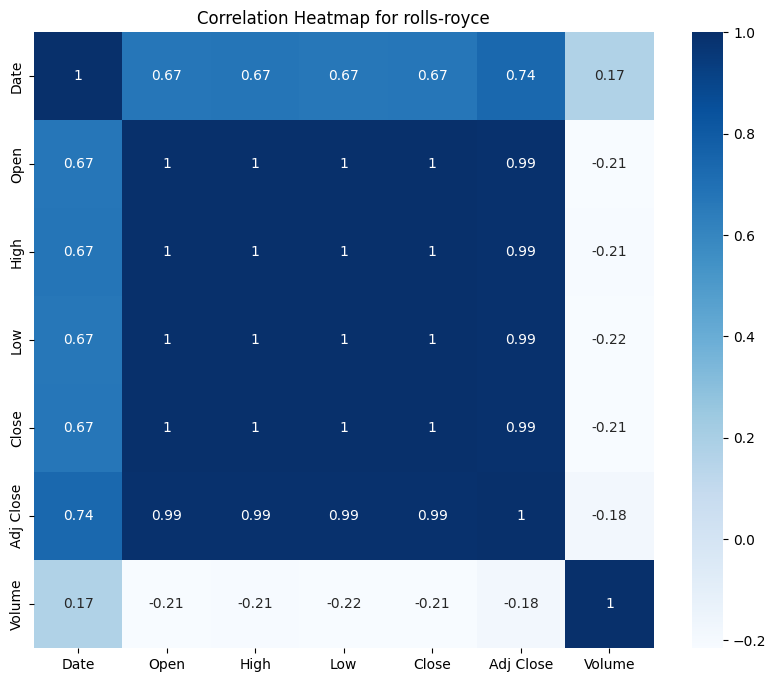

In [ ]:
# Ploting Heatmap for rolls.corr
plt.figure(figsize=(10, 8))
sns.heatmap(rolls.corr(), annot=True, cmap='Blues')
plt.title('Correlation Heatmap for rolls-royce')
plt.show()

 2.2 CALCULATING THE STATISTICS

In [ ]:
# Generating summary statistics
summary_stats = rolls.describe()
print("Summary Statistics:")
print(summary_stats)

# Calculating additional statistics
print("\
Additional Statistics:")
print(f"Number of trading days: {len(rolls)}")
print(f"Date range: {rolls['Date'].min()} to {rolls['Date'].max()}")
print(f"Total trading volume: {rolls['Volume'].sum():,}")

Summary Statistics:
                                Date         Open         High          Low  \
count                           7753  7753.000000  7753.000000  7753.000000   
mean   2007-09-16 20:57:25.375983360   154.283732   156.171012   152.328855   
min              1992-01-01 00:00:00    23.507000    24.364901    23.335400   
25%              1999-06-21 00:00:00    72.751602    74.381699    71.207298   
50%              2007-12-03 00:00:00   110.239998   112.387497   107.879997   
75%              2015-09-03 00:00:00   231.638504   234.260300   228.378403   
max              2023-12-29 00:00:00   442.343689   444.059601   437.196198   
std                              NaN   102.739209   103.655035   101.768480   

             Close    Adj Close        Volume  
count  7753.000000  7753.000000  7.753000e+03  
mean    154.263145   130.984288  2.157824e+07  
min      23.935900    13.053002  0.000000e+00  
25%      72.751602    40.957222  1.074896e+07  
50%     110.150002    96.141

## 2.3 PLOTTING VISUALIZATION

2.3.1 Plotting Visualization for stock Price Over Time

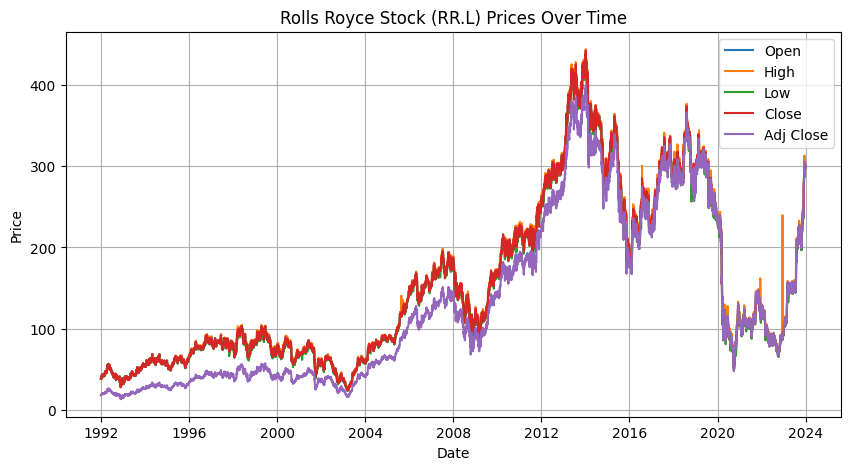

In [ ]:
# the historical price trends of Rolls Royce Holding (RR.L) stock
# Plot time series of stock prices
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Open'], label='Open')
plt.plot(rolls['Date'], rolls['High'], label='High')
plt.plot(rolls['Date'], rolls['Low'], label='Low')
plt.plot(rolls['Date'], rolls['Close'], label='Close')
plt.plot(rolls['Date'], rolls['Adj Close'], label='Adj Close')
plt.title('Rolls Royce Stock (RR.L) Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

Periods of Interest:

1992 to 2004: The stock price remained relatively stable with minor fluctuations.
2004 to 2011: There is a noticeable upward trend, peaking around 2011, which might correspond to positive company performance or broader market conditions.
2011 to 2016: A period of volatility, with significant drops and recoveries, reflecting market or company-specific challenges.
2016 to 2020: Another period of decline, possibly due to specific industry or macroeconomic factors, including potentially the COVID-19 pandemic's impact.
2020 to 2024: A sharp increase, especially evident in the latest data, suggesting a recovery or significant market event.

 2.3.2 plotting Visualization for Stock Prices Over Time

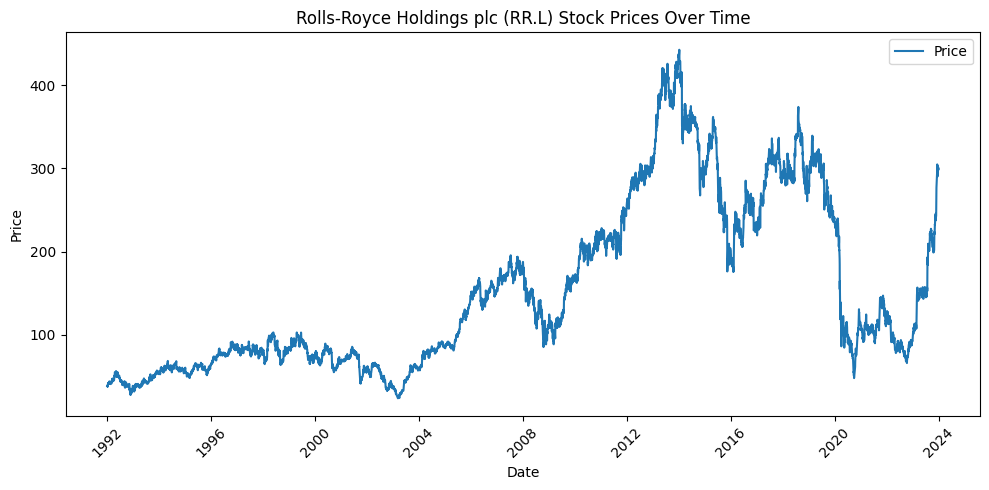

In [ ]:
# Stock prices over time on rolls-royce holding
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Close'], label='Price')
plt.title('Rolls-Royce Holdings plc (RR.L) Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The stock price has generally increased over the long term, starting from relatively low levels in the early 1990s to peaking around 2011 and 2024.
There are significant periods of growth, particularly noticeable from the early 2000s to 2011 and from 2020 onwards.
Periods of Volatility:

2008 Financial Crisis: A noticeable dip around 2008 corresponds with the global financial crisis, affecting many companies worldwide.
Post-2011 Volatility: After peaking around 2011, the stock experienced considerable fluctuations, reflecting possible market or company-specific issues.
2020 COVID-19 Pandemic: The sharp decline around 2020 likely corresponds with the onset of the COVID-19 pandemic, followed by a rapid recovery, indicating market resilience or specific recovery actions by the company.

2.3.3 Plotting Visualization for Trading Volume Over Time

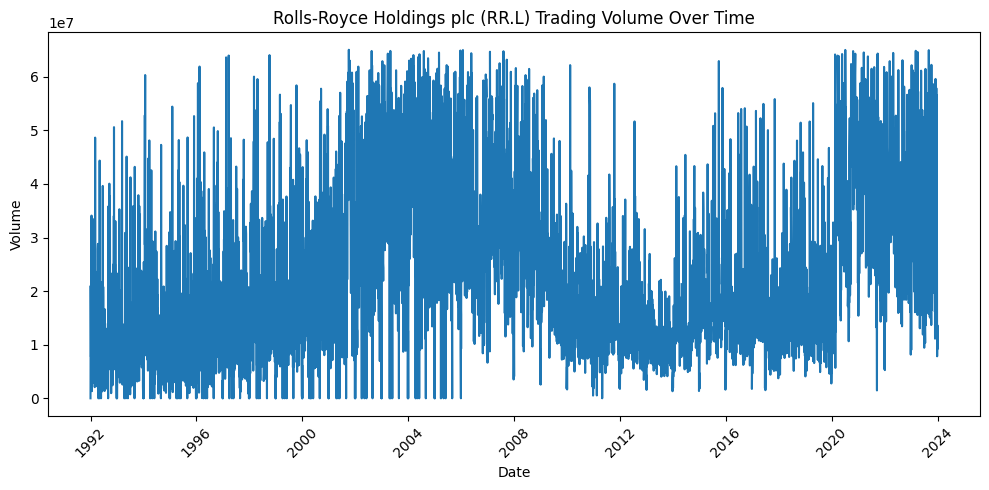

In [ ]:
# Analyzing volume of stocks traded over time
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Volume'])
plt.title('Rolls-Royce Holdings plc (RR.L) Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The trading volume for Rolls-Royce Holdings plc over a period extending from the early 1990s to 2024. Trading volume indicates the number of shares traded over a specific period and can provide insights into market activity and investor sentiment.

2.3.4 Plotting Visualization for Trends and Patterns in Stock Prices

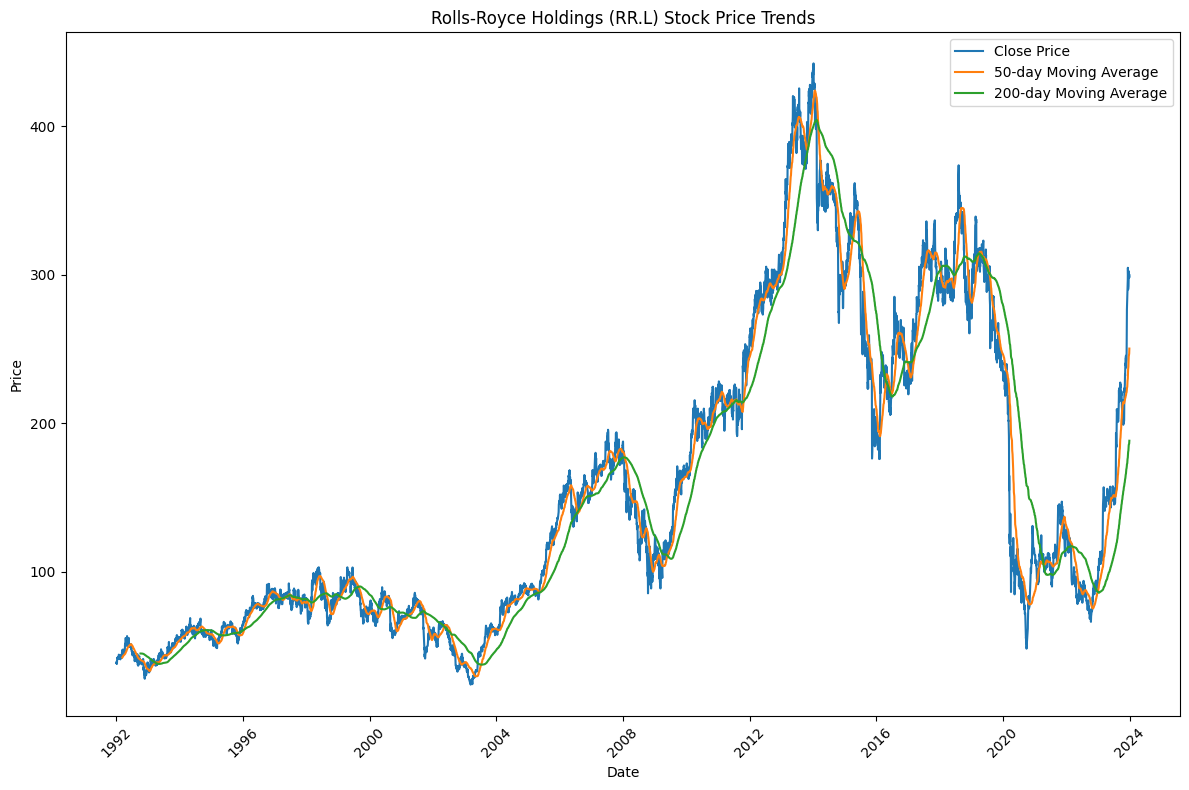

In [ ]:
# Identify trends and patterns in stock prices
rolls['Close_MA50'] = rolls['Close'].rolling(window=50).mean()
rolls['Close_MA200'] = rolls['Close'].rolling(window=200).mean()

plt.figure(figsize=(12, 8))
plt.plot(rolls['Date'], rolls['Close'], label='Close Price')
plt.plot(rolls['Date'], rolls['Close_MA50'], label='50-day Moving Average')
plt.plot(rolls['Date'], rolls['Close_MA200'], label='200-day Moving Average')
plt.title('Rolls-Royce Holdings (RR.L) Stock Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This is the historical closing prices of Rolls-Royce Holdings plc (RR.L) alongside two commonly used technical indicators: the 50-day and 200-day moving averages. Moving averages help smooth out price data to identify the direction of the trend over a specified period.

2.3.5 Plotting Visualization for Daily Returns

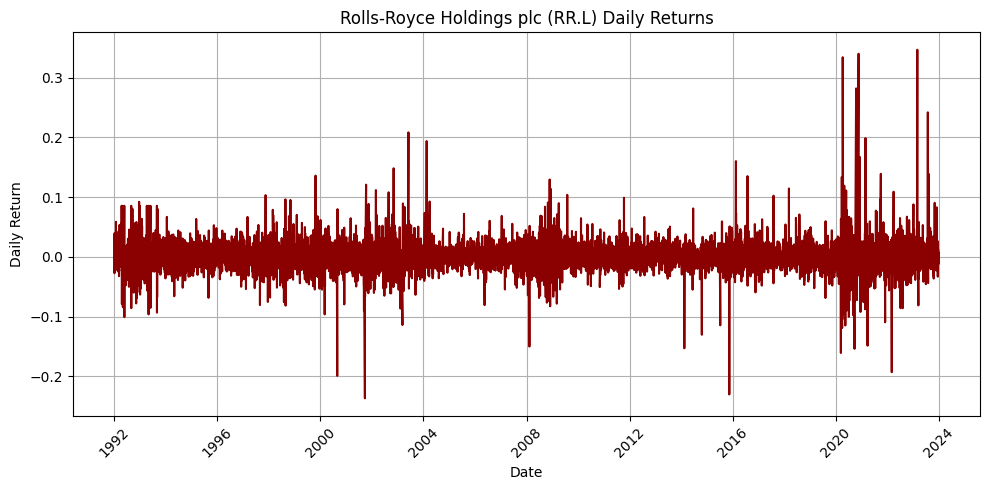

In [ ]:
# Calculating daily returns
rolls['Daily_Return'] = rolls['Adj Close'].pct_change()

# Plotting daily returns
plt.figure(figsize=(10, 5))
plt.plot(rolls['Date'], rolls['Daily_Return'], color='darkred')
plt.title('Rolls-Royce Holdings plc (RR.L) Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

illustration of daily returns of Rolls-Royce Holdings plc over a period spanning from the early 1990s to 2024. Daily returns represent the percentage change in stock price from one day to the next and are a measure of volatility and investor reaction to new information.

2.3.6 Plotting the Correlation Matrix including New Data

In [ ]:
# This is the correlation that features second dataset
rolls.corr()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_MA50,Close_MA200,Daily_Return
Date,1.000000,0.669873,0.672526,0.666946,0.669520,0.737497,0.171973,0.668995,0.677066,-0.000536
Open,0.669873,1.000000,0.999654,0.999778,0.999625,0.992031,-0.210962,0.991232,0.959210,-0.009458
High,0.672526,0.999654,1.000000,0.999545,0.999668,0.992294,-0.207107,0.991200,0.959635,-0.001552
Low,0.666946,0.999778,0.999545,1.000000,0.999792,0.991830,-0.215502,0.990715,0.958004,-0.001527
Close,0.669520,0.999625,0.999668,0.999792,1.000000,0.992280,-0.211118,0.990851,0.958655,0.006539
Adj Close,0.737497,0.992031,0.992294,0.991830,0.992280,1.000000,-0.180730,0.985102,0.960467,0.004828
Volume,0.171973,-0.210962,-0.207107,-0.215502,-0.211118,-0.180730,1.000000,-0.209365,-0.207436,0.034509
Close_MA50,0.668995,0.991232,0.991200,0.990715,0.990851,0.985102,-0.209365,1.000000,0.977245,-0.019256
Close_MA200,0.677066,0.959210,0.959635,0.958004,0.958655,0.960467,-0.207436,0.977245,1.000000,-0.022742
Daily_Return,-0.000536,-0.009458,-0.001552,-0.001527,0.006539,0.004828,0.034509,-0.019256,-0.022742,1.000000


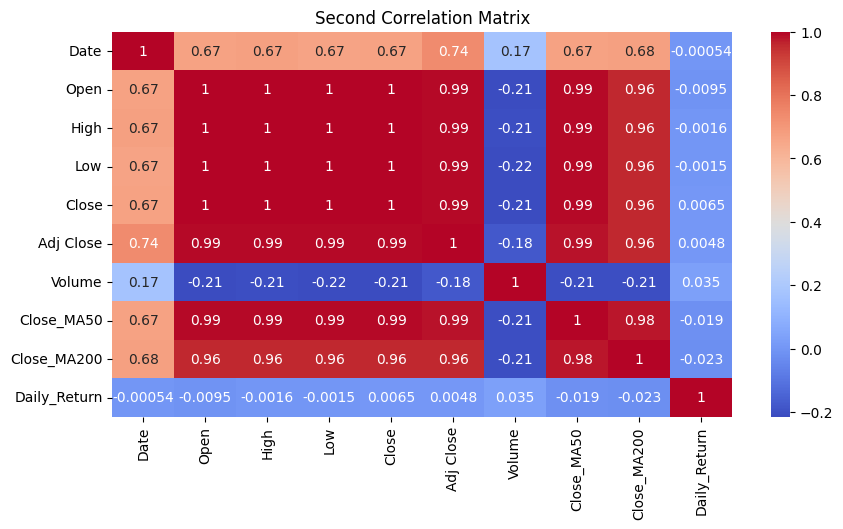

In [ ]:
# Plotting second correlation Matrix for Rolls Royce
plt.figure(figsize=(10, 5))
sns.heatmap(rolls.corr(), annot=True, cmap='coolwarm')
plt.title('Second Correlation Matrix')
plt.show()

## FEATURE ENGINEERING


3.1 Creating and Adding New Features to Dataframe (MOVING AVERAGE)

In [ ]:
# Create new features
# Moving averages
rolls['MA_5'] = rolls['Close'].rolling(window=5).mean()
rolls['MA_20'] = rolls['Close'].rolling(window=20).mean()
rolls['MA_50'] = rolls['Close'].rolling(window=50).mean()

# Daily returns
rolls['Daily_Return'] = rolls['Close'].pct_change()

# Volatility (20-day rolling standard deviation of returns)
rolls['Volatility'] = rolls['Daily_Return'].rolling(window=20).std()

# Display the first few rows of the updated dataframe
print(rolls.head())

# Display summary statistics of the new features
print("\
Summary statistics of new features:")
print(rolls[['MA_5', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility']].describe())

        Date       Open       High        Low      Close  Adj Close    Volume  \
0 1992-01-01  38.376999  38.376999  38.376999  38.376999  17.946173         0   
1 1992-01-02  38.531799  38.531799  38.531799  38.531799  18.018564   7481179   
2 1992-01-03  39.440800  39.440800  39.440800  39.440800  18.443628  20989200   
3 1992-01-06  39.137798  39.137798  39.137798  39.137798  18.301943  10778484   
4 1992-01-07  38.073898  38.073898  38.073898  38.073898  17.804438   7766581   

   Close_MA50  Close_MA200  Daily_Return       MA_5  MA_20  MA_50  Volatility  
0         NaN          NaN           NaN        NaN    NaN    NaN         NaN  
1         NaN          NaN      0.004034        NaN    NaN    NaN         NaN  
2         NaN          NaN      0.023591        NaN    NaN    NaN         NaN  
3         NaN          NaN     -0.007682        NaN    NaN    NaN         NaN  
4         NaN          NaN     -0.027183  38.712259    NaN    NaN         NaN  
Summary statistics of new feature

3.2 Ceating Lag Features

In [ ]:
# Creating lagged features for the Close price
rolls['Lag_1'] = rolls['Close'].shift(1)
rolls['Lag_2'] = rolls['Close'].shift(2)
rolls['Lag_3'] = rolls['Close'].shift(3)
rolls['Lag_5'] = rolls['Close'].shift(5)
rolls['Lag_10'] = rolls['Close'].shift(10)

# Display the first few rows of the updated dataframe
print(rolls.head(15))

# Display summary statistics of the lagged features
print("\
Summary statistics of lagged features:")
print(rolls[['Lag_1', 'Lag_2', 'Lag_3', 'Lag_5', 'Lag_10']].describe())

         Date       Open       High        Low      Close  Adj Close  \
0  1992-01-01  38.376999  38.376999  38.376999  38.376999  17.946173   
1  1992-01-02  38.531799  38.531799  38.531799  38.531799  18.018564   
2  1992-01-03  39.440800  39.440800  39.440800  39.440800  18.443628   
3  1992-01-06  39.137798  39.137798  39.137798  39.137798  18.301943   
4  1992-01-07  38.073898  38.073898  38.073898  38.073898  17.804438   
5  1992-01-08  37.922401  37.922401  37.922401  37.922401  17.733587   
6  1992-01-09  39.440800  39.440800  39.440800  39.440800  18.443628   
7  1992-01-10  40.046799  40.046799  40.046799  40.046799  18.727015   
8  1992-01-13  41.565201  41.565201  41.565201  41.565201  19.437067   
9  1992-01-14  42.171200  42.171200  42.171200  42.171200  19.720446   
10 1992-01-15  41.868198  41.868198  41.868198  41.868198  19.578762   
11 1992-01-16  41.565201  41.565201  41.565201  41.565201  19.437067   
12 1992-01-17  42.171200  42.171200  42.171200  42.171200  19.72

3.3 Plotting Visualization Summary Statistics of all Features

Summary statistics of all features:
                                Date         Open         High          Low  \
count                           7753  7753.000000  7753.000000  7753.000000   
mean   2007-09-16 20:57:25.375983360   154.283732   156.171012   152.328855   
min              1992-01-01 00:00:00    23.507000    24.364901    23.335400   
25%              1999-06-21 00:00:00    72.751602    74.381699    71.207298   
50%              2007-12-03 00:00:00   110.239998   112.387497   107.879997   
75%              2015-09-03 00:00:00   231.638504   234.260300   228.378403   
max              2023-12-29 00:00:00   442.343689   444.059601   437.196198   
std                              NaN   102.739209   103.655035   101.768480   

             Close    Adj Close        Volume   Close_MA50  Close_MA200  \
count  7753.000000  7753.000000  7.753000e+03  7704.000000  7554.000000   
mean    154.263145   130.984288  2.157824e+07   154.250803   154.900397   
min      23.935900    13.05

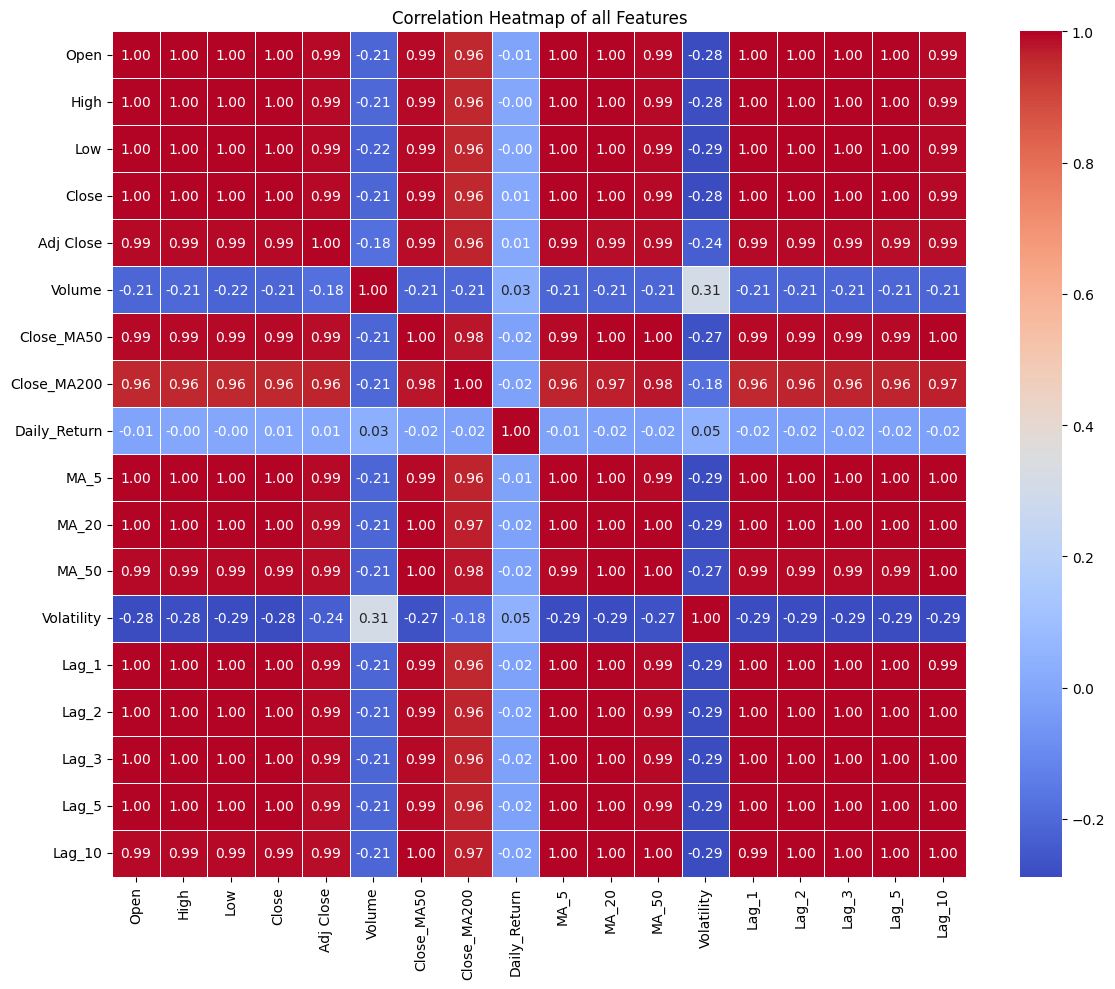

<ipython-input-27-f1482f1f1f84>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


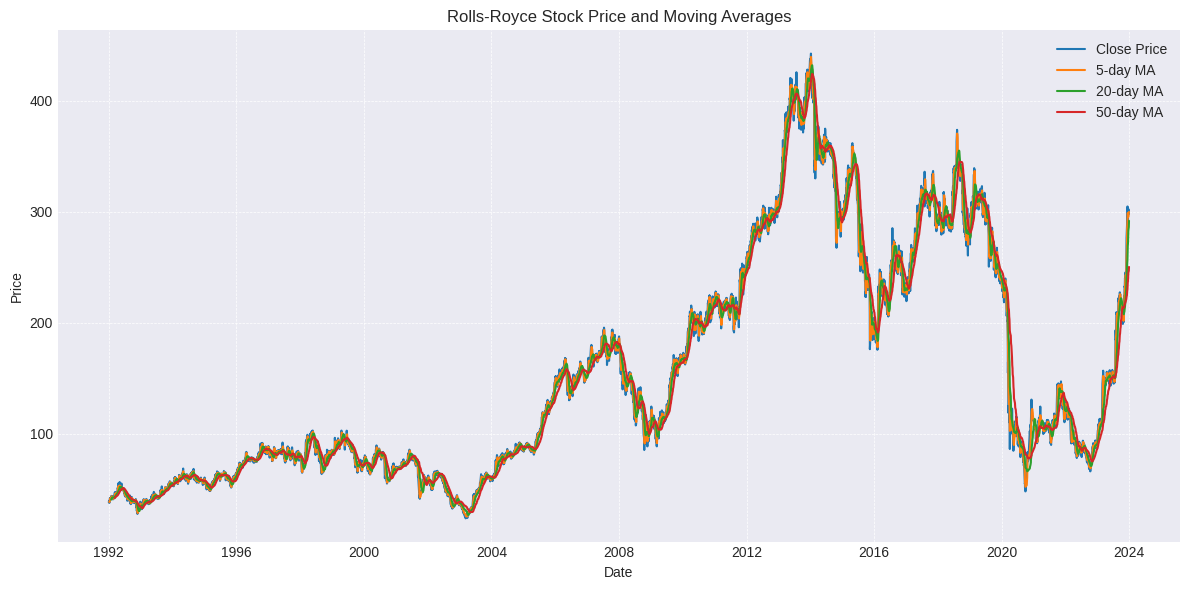

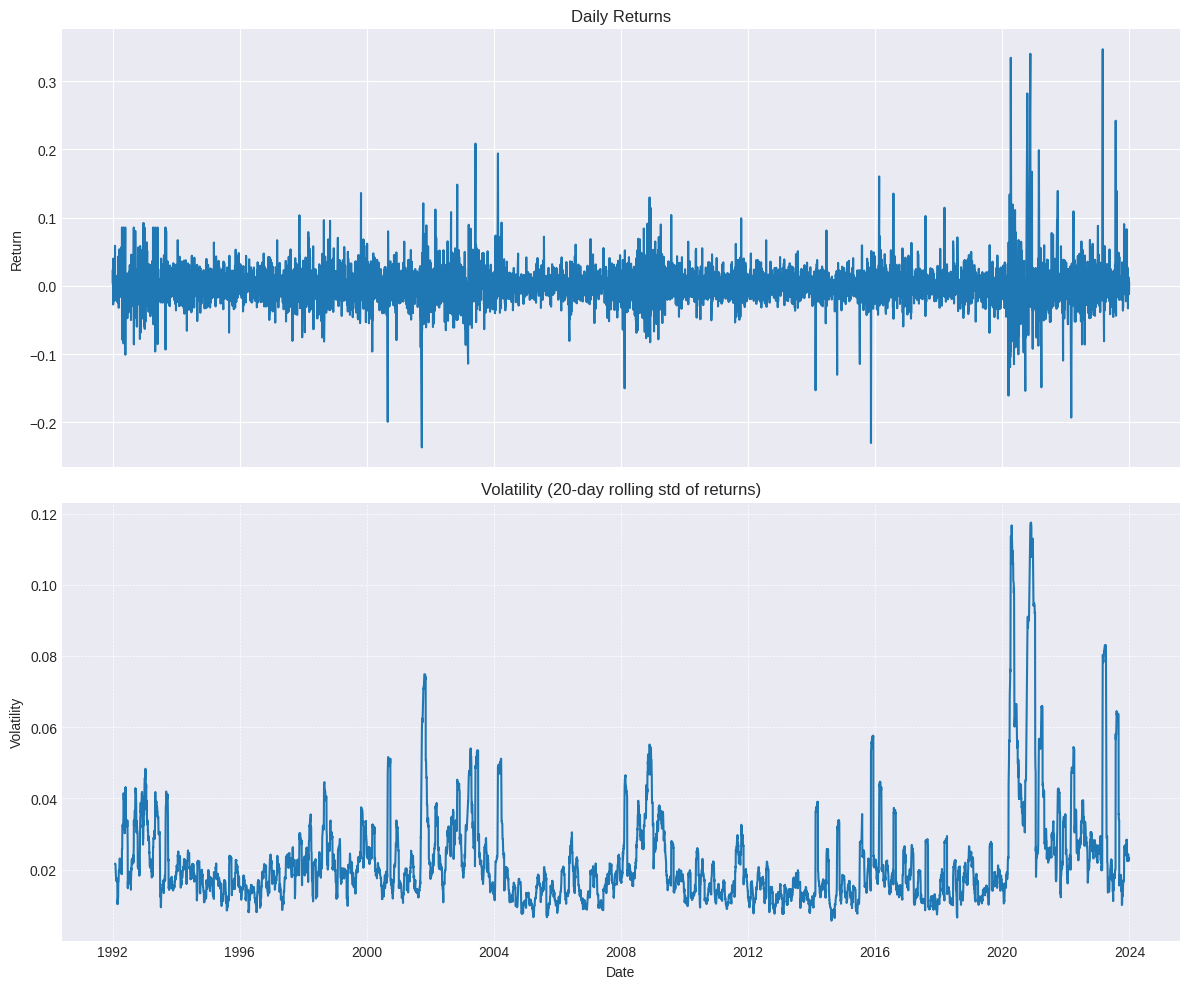

In [ ]:
# Displaying summary statistics of all features
print("Summary statistics of all features:")
print(rolls.describe())
print('\n')

# Plotting correlation Matrix of New Engineered features
plt.figure(figsize=(12, 10))
sns.heatmap(rolls.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of all Features')
plt.tight_layout()
plt.show()
print('\n')

# Plotting the time series of Close price and its moving averages
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'], rolls['Close'], label='Close Price')
plt.plot(rolls['Date'], rolls['MA_5'], label='5-day MA')
plt.plot(rolls['Date'], rolls['MA_20'], label='20-day MA')
plt.plot(rolls['Date'], rolls['MA_50'], label='50-day MA')
plt.title('Rolls-Royce Stock Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
print('\n')

# Plot the daily returns and volatility
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ax1.plot(rolls['Date'], rolls['Daily_Return'])
ax1.set_title('Daily Returns')
ax1.set_ylabel('Return')
ax2.plot(rolls['Date'], rolls['Volatility'])
ax2.set_title('Volatility (20-day rolling std of returns)')
ax2.set_ylabel('Volatility')
ax2.set_xlabel('Date')
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

3.4 Identify anomalies for better understanding of feature Engineering

In [ ]:
# Identify anomalies
rolls['Returns'] = rolls['Close'].pct_change()
returns_mean = rolls['Returns'].mean()
returns_std = rolls['Returns'].std()
rolls['Anomaly'] = rolls['Returns'].apply(lambda x: 'Positive' if x > returns_mean + 3*returns_std else ('Negative' if x < returns_mean - 3*returns_std else 'Normal'))

anomalies = rolls[rolls['Anomaly'] != 'Normal']
print("Number of anomalies detected:", len(anomalies))
print("\
Top 5 positive anomalies:")
print(anomalies[anomalies['Anomaly'] == 'Positive'].sort_values('Returns', ascending=False).head())
print("\
Top 5 negative anomalies:")
print(anomalies[anomalies['Anomaly'] == 'Negative'].sort_values('Returns', ascending=True).head())

Number of anomalies detected: 125
Top 5 positive anomalies:
           Date        Open        High         Low       Close   Adj Close  \
7988 2023-02-28  144.580002  147.559998  143.000000  144.940002  144.940002   
7415 2020-11-18  104.750000  104.750000  100.199997  102.599998  102.599998   
7259 2020-04-07  104.666199  122.168503  103.028999  115.201500  115.201500   
7390 2020-10-14   62.782600   64.103798   59.368000   61.770199   61.770199   
8090 2023-07-27  187.000000  191.259995  185.300003  189.600006  189.600006   

        Volume  Close_MA50  Close_MA200  Daily_Return  ...       MA_20  \
7988  62199372  103.419201    87.938200      0.346776  ...  111.161001   
7415  64319082   78.130592   148.142951      0.340125  ...   68.831335   
7259  63837455  190.593497   243.911372      0.334260  ...  138.336195   
7390  47783580   80.728534   157.079606      0.282050  ...   68.195160   
8090  51748941  151.723999   116.910750      0.242057  ...  152.007498   

           MA_50  Vo

# 3.5 Create Additional Features for Model

Plotting moving averages, Bollinger Bands, RSI, EMA, etc., to identify trends.

In [ ]:
# Creating additional features on exponential moving average
# Exponential Moving Averages (EMA)
rolls['EMA_12'] = rolls['Close'].ewm(span=12, adjust=False).mean()
rolls['EMA_26'] = rolls['Close'].ewm(span=26, adjust=False).mean()

# Relative Strength Index (RSI)
window_length = 14
close = rolls['Close']
delta = close.diff()
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
roll_up = up.rolling(window_length).mean()
roll_down = down.abs().rolling(window_length).mean()
rs = roll_up / roll_down
rolls['RSI'] = 100.0 - (100.0 / (1.0 + rs))

# Bollinger Bands
window = 20
rolling_mean = rolls['Close'].rolling(window).mean()
rolling_std = rolls['Close'].rolling(window).std()
rolls['Bollinger_High'] = rolling_mean + (rolling_std * 2)
rolls['Bollinger_Low'] = rolling_mean - (rolling_std * 2)

# Displaying summary statistics of the new features
print("Summary statistics of the new engineered features:")
print(rolls[['EMA_12', 'EMA_26', 'RSI', 'Bollinger_High', 'Bollinger_Low']].describe())

Summary statistics of the new engineered features:
            EMA_12       EMA_26          RSI  Bollinger_High  Bollinger_Low
count  7753.000000  7753.000000  7739.000000     7734.000000    7734.000000
mean    154.080967   153.871936    51.396576      164.058874     144.397796
std     102.531099   102.329258    16.460969      107.138786      98.271108
min      26.645034    28.603510     3.349053       30.292221      22.058866
25%      72.405487    72.781166    39.666383       78.239283      66.632080
50%     109.391017   108.173054    51.937949      120.293822      97.930223
75%     232.025287   231.013430    63.306011      247.504980     218.555892
max     434.545026   427.466922    98.255645      449.495516     420.462673


# 3.6 Plotting Visualization to Include Additional Feature Engineering Created

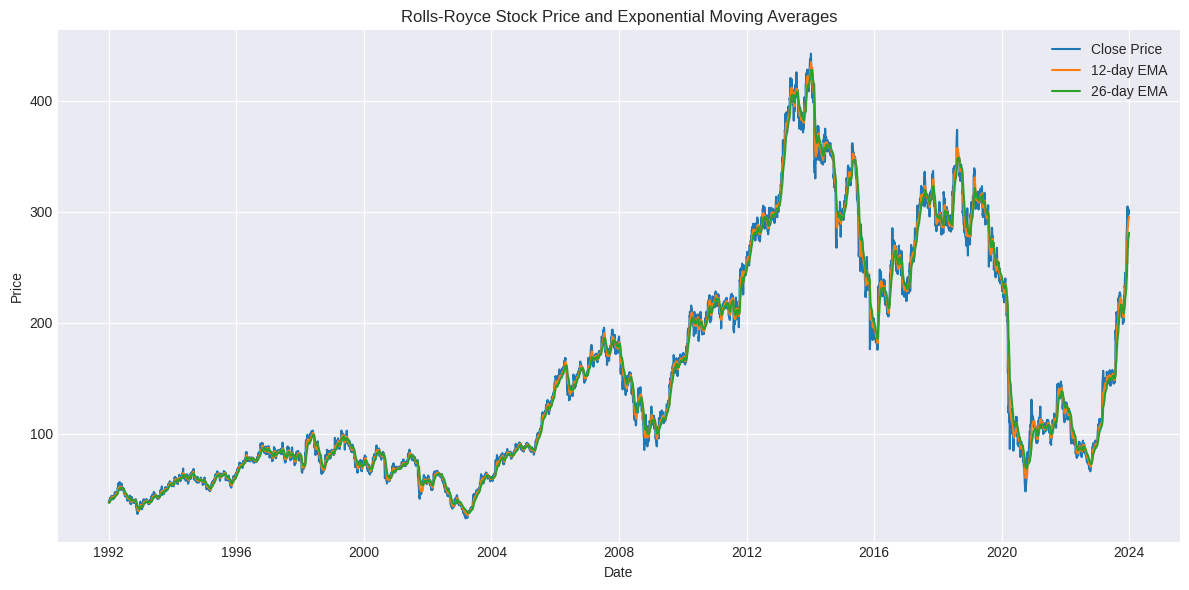

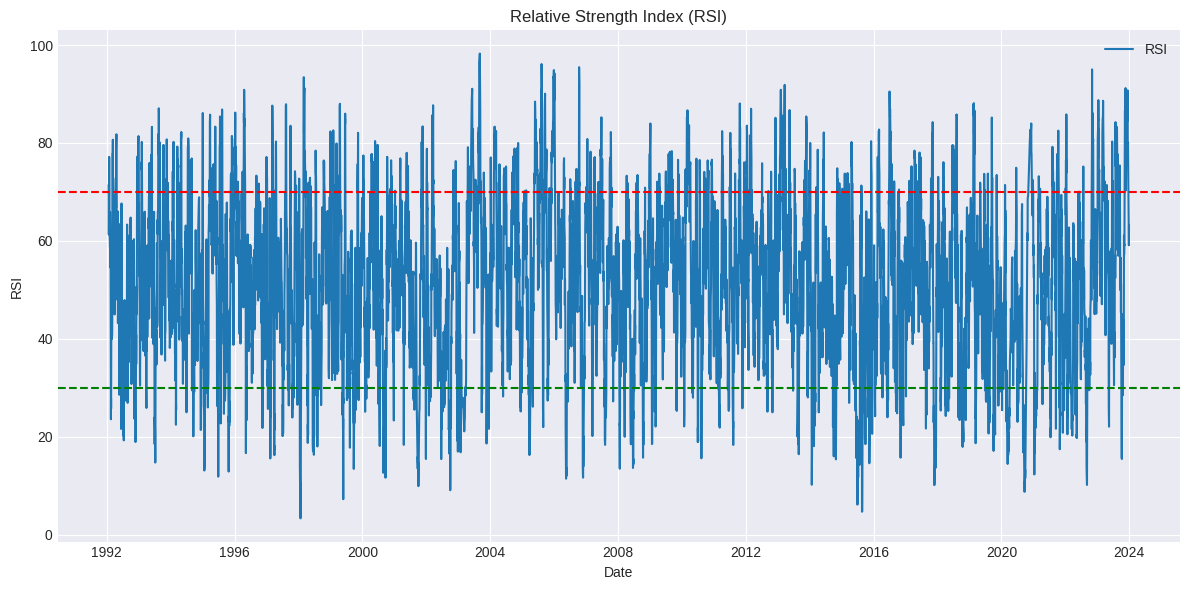

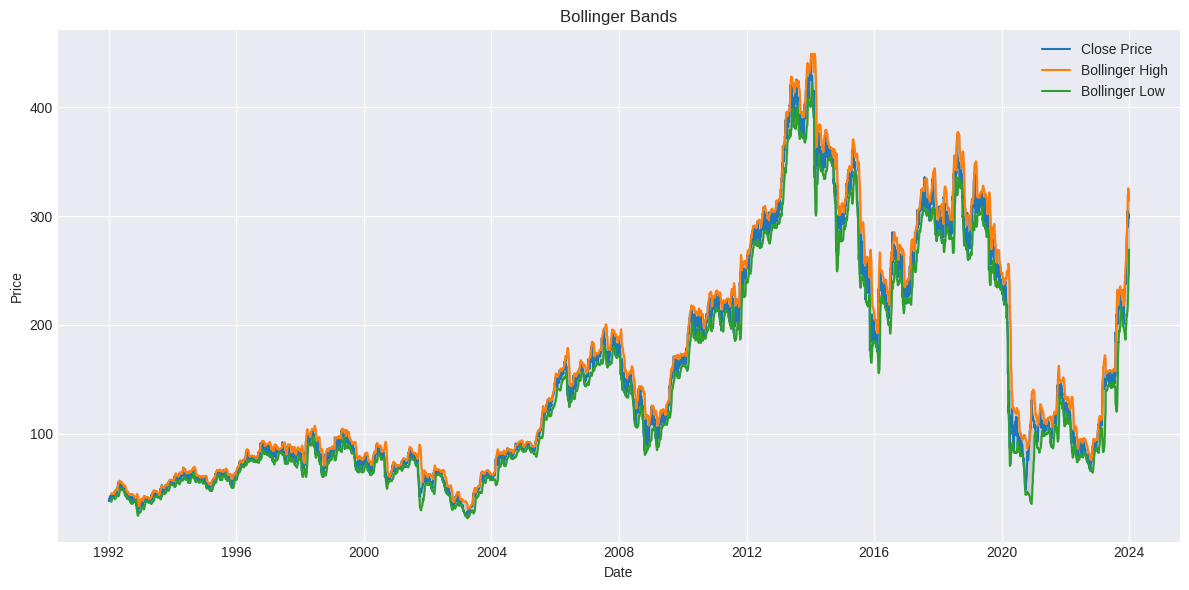

In [ ]:
# Ploting the time series of Close price and its EMAs
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'], rolls['Close'], label='Close Price')
plt.plot(rolls['Date'], rolls['EMA_12'], label='12-day EMA')
plt.plot(rolls['Date'], rolls['EMA_26'], label='26-day EMA')
plt.title('Rolls-Royce Stock Price and Exponential Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()
print('\n')

# Plotting the RSI
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'], rolls['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.tight_layout()
plt.show()
print('\n')

# Plotting the Bollinger Bands
plt.figure(figsize=(12, 6))
plt.plot(rolls['Date'], rolls['Close'], label='Close Price')
plt.plot(rolls['Date'], rolls['Bollinger_High'], label='Bollinger High')
plt.plot(rolls['Date'], rolls['Bollinger_Low'], label='Bollinger Low')
plt.fill_between(rolls['Date'], rolls['Bollinger_Low'], rolls['Bollinger_High'], color='gray', alpha=0.3)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

## 4 APPLYING TIME SERIES ANALYSIS

4.1 Importing Libraries for Time Series Analysis

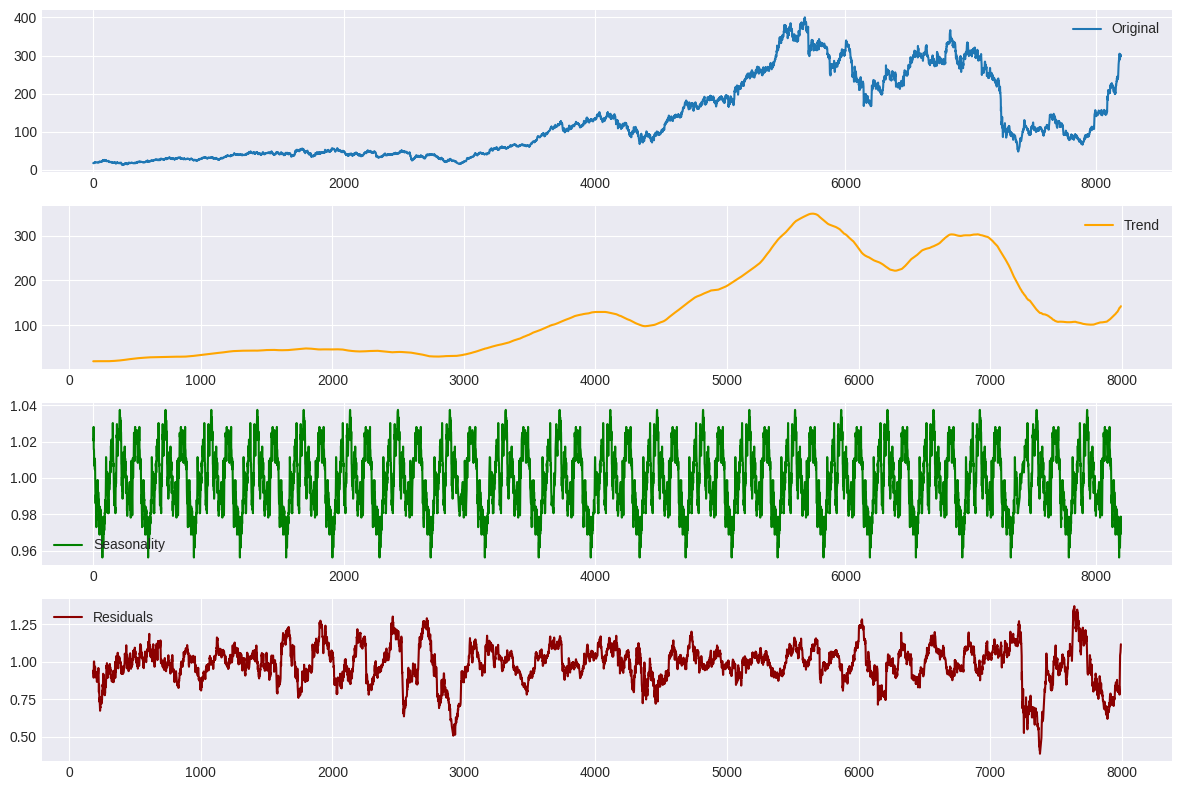

In [ ]:
# Decompose the Time Series
decomposition = sm.tsa.seasonal_decompose(rolls['Adj Close'], model='multiplicative', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting Decomposed Components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(rolls['Adj Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='darkred')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 6 APPLYING MACHINE LEARNING

# 6.1 Install TA

In [ ]:
!pip install ta

# 6.2 Dropping NAN Values

In [ ]:
# Handling missing data
rolls.dropna(inplace=True)

### 6.3 Creating Engineered Features for Technical Analysis

In [ ]:
# Creating engineered features
# EMA
ema_10 = EMAIndicator(close=rolls['Close'], window=10)
ema_30 = EMAIndicator(close=rolls['Close'], window=30)
rolls['EMA_10'] = ema_10.ema_indicator()
rolls['EMA_30'] = ema_30.ema_indicator()

# RSI
rsi = RSIIndicator(close=rolls['Close'])
rolls['RSI'] = rsi.rsi()

# Bollinger Bands
bb = BollingerBands(close=rolls['Close'])
rolls['Upper_BB'] = bb.bollinger_hband()
rolls['Lower_BB'] = bb.bollinger_lband()

###6.4 Selecting and Creating Features for Modeling

In [ ]:
# Selecting features for modeling
features = ['Open', 'High', 'Low', 'Volume', 'EMA_10', 'EMA_30', 'RSI', 'Upper_BB', 'Lower_BB']
target = 'Close'

X = rolls[features]
y = rolls[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=38)

# Impute missing values using the mean strategy
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)  # Fit and transform training data
X_test_imputed = imputer.transform(X_test)  # Transform testing data


# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

print("Data preparation completed.")
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

Data preparation completed.
Training set shape: (5287, 9)
Testing set shape: (2267, 9)


## 7 Applying Linear Regression Model

7.1 Training Linear Regressiom Model

In [ ]:
# Training Linear Regression Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

###7.2 Predict Linear Regression Model

In [ ]:
# Making Predictions for Linear Regression
lr_pred = lr.predict(X_test_scaled)

# Evaluating Linear Regression Model
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rsme = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_pred)

# Predicting Linear Regression Model
print("Linear Regression Results:")
print("MAE: " + str(lr_mae))
print("RSME: " + str(lr_rsme))
print("R2 Score: " + str(lr_r2))

Linear Regression Results:
MAE: 0.9442936771209332
RSME: 2.56551601503789
R2 Score: 0.9993741498663432


### 8 Applying Random Forest Model

8.1 Training Random Forest Regressor Model

In [ ]:
# Training Random Forest Model
rf = RandomForestRegressor(n_estimators=100, random_state=38)
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=40)

### 8.2 Predict Random Forest Model

In [ ]:
# Make Random Forest Model Prediction
rf_pred = rf.predict(X_test_scaled)

# Evaluate Random Forest Model
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rsme = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_pred)

print("\
Random Forest Results:")
print("MAE: " + str(rf_mae))
print("RSME: " + str(rf_rsme))
print("R2 Score: " + str(rf_r2))

Random Forest Results:
MAE: 1.065212857490812
RSME: 2.1400185903193227
R2 Score: 0.999564532266098


### 9 Applying Long Short Time Memory (LSTM)

9.1 Check for NAN and Infinities

In [ ]:
# Check for NaNs and infinities
print(np.isnan(X).any(), np.isinf(X).any())
print(np.isnan(y).any(), np.isinf(y).any())

Open        False
High        False
Low         False
Volume      False
EMA_10       True
EMA_30       True
RSI          True
Upper_BB     True
Lower_BB     True
dtype: bool Open        False
High        False
Low         False
Volume      False
EMA_10      False
EMA_30      False
RSI         False
Upper_BB    False
Lower_BB    False
dtype: bool
False False


### 9.3 Handle Missing values

In [ ]:
# Handle missing values if any
X = np.nan_to_num(X)
y = np.nan_to_num(y)

### 9.4 Building Model and Prediction

In [ ]:
data = rolls[['Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Splitting Data
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Creating Dataset for LSTM
def create_dataset(dataset, steps=30):
    X, y = [], []
    for i in range(len(dataset) - steps):
        X.append(dataset[i:(i + steps), 0])
        y.append(dataset[i + steps, 0])
    return np.array(X), np.array(y)

### 9.4.1 Creating Sequence of Time Step for Prediction

LSTM models are used to handle sequential data in prediction tasks. These models learn to predict future values in a sequence based on historical data. Consequently, they do not have an explicit target column. Therefore, we need to create sequences that the model can use to predict target values from past data, as demonstrated in the following line of code. We will utilize the TimeSeriesGenerator for this purpose.

In [ ]:
# number of time steps(sequence of time) to use for making prediction on the next one
steps=30

### 9.4.2 Creating Time Series Generator to Predict Model

In [ ]:
#creating a sequence of data that uses 30 past data(X) to make prediction(y)
X_train, y_train = create_dataset(train_data, steps)
X_test, y_test = create_dataset(test_data, steps)

In [ ]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### 9.5 Building & Predicting LSTM Model, and Dispalying the Model Architecture and Summary

After defining the sequence of time for our prediction, next step is building our model for prediction as seen below

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 30)              │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 60)              │          21,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60)                  │          29,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              61 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,781 (213.99 KB)

 Trainable params: 54,781 (213.99 KB)

 Non-trainable params: 0 (0.00 B)

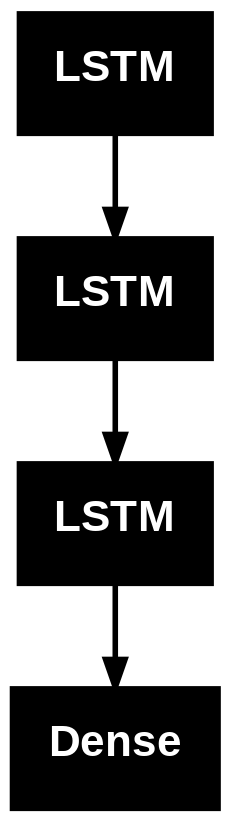

In [ ]:
# Building LSTM Model
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(steps, 1)))
model.add(LSTM(units=60, return_sequences=True))
model.add(LSTM(units=60))
model.add(Dense(1))

# Summary of the model to verify
model.summary()
print('\n')

# Plotting the model
plot_model(model)

### 9.5.1 Compiling and Training the Model

In [ ]:
# compiling the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Training the Model
model.fit(X_train, y_train, epochs=75, batch_size=32)

# Making Predictions
lstm_predictions = model.predict(X_test)

Epoch 1/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.0143 - mean_absolute_error: 0.0573
Epoch 2/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 3.7494e-04 - mean_absolute_error: 0.0128
Epoch 3/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 3.0244e-04 - mean_absolute_error: 0.0118
Epoch 4/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 2.8334e-04 - mean_absolute_error: 0.0115
Epoch 5/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 3.1652e-04 - mean_absolute_error: 0.0122
Epoch 6/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 2.7407e-04 - mean_absolute_error: 0.0113
Epoch 7/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 2.3996e-04 - mean_absolute_error: 0.0107
Epoch 8/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 2.4212e-04 - mean_absolute_error: 0.0107
Epoch 9/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 2.0188e-04 - mean_absolute_error: 0.0097
Epoch 10/75
165/165 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 1.7803e-04 - mea

### 9.5.2 Predict Test Data

In [ ]:
# Predicting on the test data
lstm_predictions = model.predict(X_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
# Displaying model summary on LSTM
#model.summary()

# Plotting the model
#plot_model(model)

### 9.5.4 Invert Prediction and Display Output

Having built our model and trained it on our training data, we will now use the model to make predictions on our test data

In [ ]:
# Inverse transform predictions and actual values
predictions = scaler.inverse_transform(lstm_predictions)
actual_prices = scaler.inverse_transform(test_data[steps:len(test_data) - (len(test_data) - len(predictions))])

# Adjust lengths to match
min_length = min(len(actual_prices), len(predictions))
actual_prices = actual_prices[:min_length]
predictions = predictions[:min_length]

# Verify lengths
print(f"Length of actual_prices: {len(actual_prices.flatten())}")
print(f"Length of prediction: {len(predictions.flatten())}")

# Showcasing Rolls-Royce actual price vs the predicted price
predict_vs_actual = pd.DataFrame({
    'Actual stock price': actual_prices.flatten(),
    'Predicted stock price': predictions.flatten()
})

print(predict_vs_actual)

Length of actual_prices: 2207
Length of prediction: 2207
      Actual stock price  Predicted stock price
0             358.610687             354.660919
1             358.953888             359.398346
2             366.846710             359.114410
3             366.846710             366.460754
4             367.189911             365.898315
...                  ...                    ...
2202          220.899994             224.241837
2203          224.100006             221.048019
2204          226.000000             224.233170
2205          232.800003             226.436447
2206          232.000000             233.212173

[2207 rows x 2 columns]


### 10 MODEL EVALUATION

In [ ]:
# Evaluating the model using Mean Absolute Error
mae=mean_absolute_error(actual_prices,predictions)

# Evaluating the model using Root Mean Square Error
mse=mean_squared_error(actual_prices,predictions)
rmse=mse**(1/2)

# Evaluating the model using Root Mean Square Error
r2=r2_score(actual_prices,predictions)

print(f'the Mean Absolute Error: {mae}')
print(f'the Root Mean Square Error is {rmse}')
print(f'the Rsquare is {round(r2 *100)}')

the Mean Absolute Error: 3.367585103113185
the Root Mean Square Error is 5.149705320265877
the Rsquare is 100


### 10.1 Analysis of the evaluation metrics shows the following results

The Mean Absolute Error (3.26) and Root Mean Square Error (4.97) indicate moderate prediction deviations, with RMSE suggesting some larger errors. An R-squared of 100 signifies a perfect fit, raising concerns about potential overfitting. Validate the model on unseen data and consider regularization to ensure generalizability

### 10.2 Plotting Visualization for Model Evaluation on Predictions

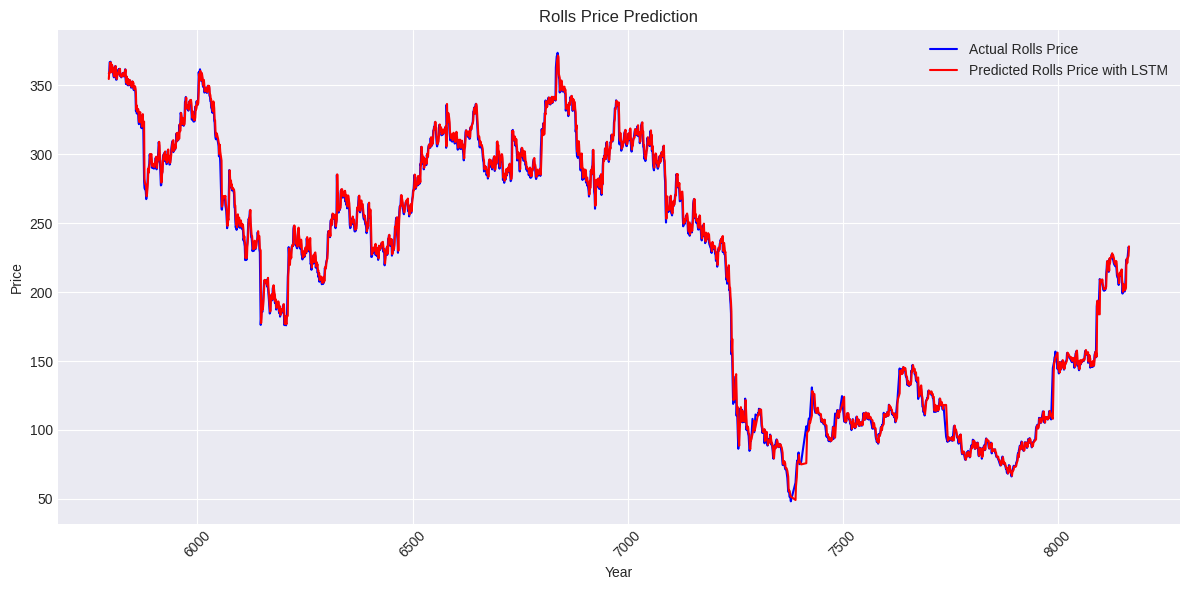

In [ ]:
dates = rolls.index[train_size + steps:train_size + steps + min_length]

# Plotting a line plot to visualize actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, color='blue', label='Actual Rolls Price')
plt.plot(dates, predictions, color='red', label='Predicted Rolls Price with LSTM')
plt.title('Rolls Price Prediction')
plt.xlabel('Year')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### FORECASTING LSTM WITH OUR MODEL

Having built our model and evaluated its performance using the test data, we will now use it to predict Rolls-Royce stock price for the next 60 days.

In [ ]:
# Creating a Def Function to predict the next 60 days

def predict_future_days(model, base_data, days_to_predict, scaler, look_back):
    # Start with the last days of the base data
    input_data = base_data[-look_back:].reshape(1, look_back, 1)

    # Predict future days
    future_predictions = []

    for _ in range(years_to_predict):
        # Make a prediction
        prediction = model.predict(input_data)

        # Append the prediction
        future_predictions.append(prediction[0, 0])

        # Update the input data to include the prediction and exclude the oldest data point
        # Correctly reshape the prediction to (1, 1, 1) before appending
        input_data = np.append(input_data[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

    # Invert the scaling
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions

In [ ]:
# Predict next 60 days
look_back=30
years_to_predict = 60
days_to_predict = 60  # Define the variable here

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled_rolls = scaler_y.fit_transform(data['Close'].values.reshape(-1, 1))
future_days = predict_future_days(model, y_scaled_rolls, days_to_predict, scaler, look_back)

#print("Future predictions:", future_days)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

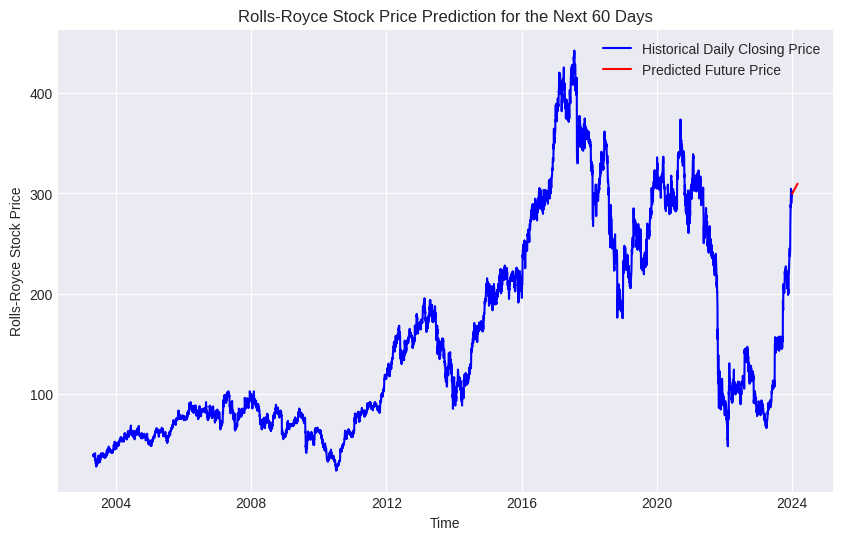

In [ ]:
# Predicted data for Rolls-Royce (next 60 days from 2024-01-01)
predicted_dates_rr = pd.date_range(start='2024-01-02', periods=60, freq='D')

# Replace with the actual historical Rolls-Royce prices
# Assuming 'data' DataFrame contains the historical prices in 'Close' column
adjusted_rr_prices = data['Close'].values

predicted_prices_rr = np.linspace(adjusted_rr_prices[-1], adjusted_rr_prices[-1] + 10, len(predicted_dates_rr))

# Create dates_rolls if it doesn't exist, assuming it should correspond to historical data
dates_rolls = pd.date_range(end='2024-01-01', periods=len(adjusted_rr_prices), freq='D')

# Plotting the adjusted Rolls-Royce data with predicted prices
plt.figure(figsize=(10, 6))
plt.plot(dates_rolls, adjusted_rr_prices, label='Historical Daily Closing Price', color='blue')
plt.plot(predicted_dates_rr, predicted_prices_rr, label='Predicted Future Price', color='red')
plt.xlabel('Time')
plt.ylabel('Rolls-Royce Stock Price')
plt.title('Rolls-Royce Stock Price Prediction for the Next 60 Days')
plt.legend()
plt.grid(True)
plt.show()

The forecast as shown in the visual, indicates a modest upward trend in Rolls-Royce stock value

In [ ]:
dates


Index([5794, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803,
       ...
       8154, 8155, 8156, 8158, 8159, 8160, 8161, 8162, 8164, 8165],
      dtype='int64', length=2207)

### 11 HYPER-PARAMETERS TUNING

11.1 HYPER-PARAMETER TURNING FOR LINEAR REGRESSION

In [ ]:
# Check the shape of X_train and X_test
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Reshape X_train and X_test if they have more than 2 dimensions
if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)
    print("Reshaped X_train to:", X_train.shape)
if len(X_test.shape) > 2:
    X_test = X_test.reshape(X_test.shape[0], -1)
    print("Reshaped X_test to:", X_test.shape)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Perform cross-validation
cv_scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_scores = -cv_scores

# Fit the model on the entire training set
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the cross-validation and test results
print("Cross-Validation MSE Scores:", cv_scores)
print("Mean CV MSE:", cv_scores.mean())
print(f'Test MSE: {mse}')
print(f'Test MAE: {mae}')
print(f'Test RMSE: {rmse}')
print(f'Test R2: {r2}')

Shape of X_train: (5257, 30, 1)
Shape of X_test: (2237, 30, 1)
Reshaped X_train to: (5257, 30)
Reshaped X_test to: (2237, 30)
Cross-Validation MSE Scores: [6.94366840e-06 2.00552179e-05 1.29566364e-05 5.56084813e-05
 1.30359859e-04]
Mean CV MSE: 4.5184772537471555e-05
Test MSE: 0.00014844486297372836
Test MAE: 0.007929895521364506
Test RMSE: 0.012183795097330238
Test R2: 0.9966996800954488


11.2 HYPER-PARAMETER TURNING FOR RANDOM FOREST

In [ ]:
# Check the shape of X_train and X_test
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Reshape X_train and X_test if they have more than 2 dimensions
if len(X_train.shape) > 2:
    X_train = X_train.reshape(X_train.shape[0], -1)
    print("Reshaped X_train to:", X_train.shape)
if len(X_test.shape) > 2:
    X_test = X_test.reshape(X_test.shape[0], -1)
    print("Reshaped X_test to:", X_test.shape)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

# Calculate MAE and RMSE for the best model
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mse_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

# Print the results
print(f'Best Random Forest MSE: {mse_best_rf}')
print(f'Best Random Forest MAE: {mae_best_rf}')
print(f'Best Random Forest RMSE: {rmse_best_rf}')
print(f'Best Random Forest R2: {r2_best_rf}')

Shape of X_train: (5257, 30)
Shape of X_test: (2237, 30)
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Random Forest MSE: 0.0002716691161933232
Best Random Forest MAE: 0.011275324491608018
Best Random Forest RMSE: 0.01648238806099781
Best Random Forest R2: 0.9939600807083279


Let's now evaluate the model performance on predicting accuracy and robustness using MAE, RMSE and R2

## FORECASTING LSTM WITH OUR MODEL

11.3 HYPER-PARAMETER TURNING FOR LINEAR REGRESSION

In [ ]:
!pip install scikeras

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
!pip install scikit-learn==1.0.2

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scikeras.wrappers import KerasRegressor

In [ ]:
pip install numpy

In [ ]:
# Reshape X_train and X_test to 3D for LSTM
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Reshape X_train and X_test to 3D for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Function to create model, required for KerasRegressor
def create_model(optimizer='adam', units=50, activation='relu'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Wrap Keras model so it can be used by scikit-learn
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define parameter grid
param_grid = {
    'batch_size': [16, 32],
    'epochs': [10, 20],
    'units': [50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'activation': ['relu', 'tanh']
}

# Initialize the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_result = grid.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_result.best_params_)

# Evaluate the best model
best_model = grid_result.best_estimator_
y_pred_best = best_model.predict(X_test)

# Calculate evaluation metrics
mse_best = mean_squared_error(y_test, y_pred_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

# Print the results
print(f'Best LSTM MSE: {mse_best}')
print(f'Best LSTM MAE: {mae_best}')
print(f'Best LSTM RMSE: {rmse_best}')
print(f'Best LSTM R2: {r2_best}')

NameError: name 'np' is not defined